/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-7-a54452c11ad6>:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_pattern['cluster'] = cluster_labels


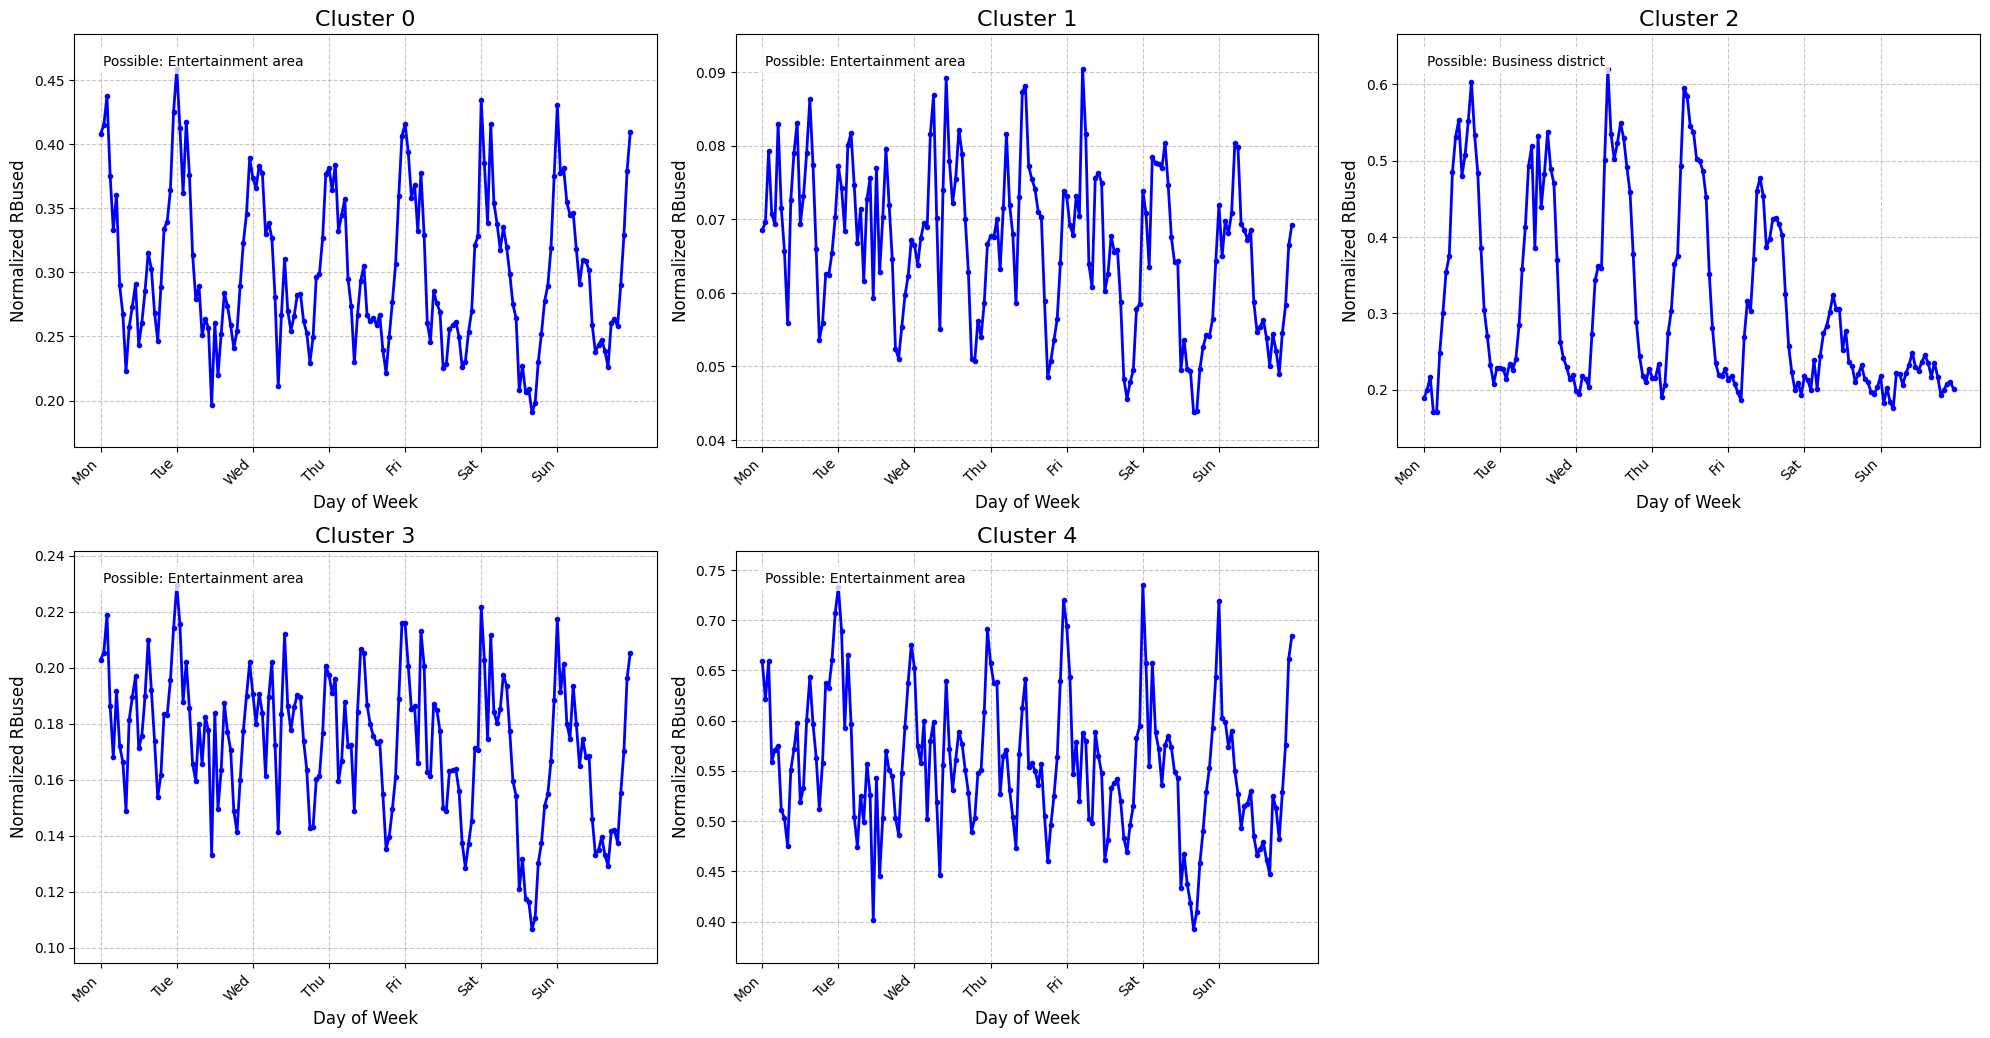


Cluster 0:
Number of cells: 104
Average RBused: 28.22
Max RBused: 100.06
Weekday to Weekend ratio: 0.98
Morning peak: 26.44
Evening peak: 38.98
Night average: 30.10
Mixed characteristics

Cluster 1:
Number of cells: 260
Average RBused: 6.28
Max RBused: 54.31
Weekday to Weekend ratio: 1.08
Morning peak: 6.71
Evening peak: 8.71
Night average: 6.59
Mixed characteristics

Cluster 2:
Number of cells: 38
Average RBused: 31.97
Max RBused: 138.24
Weekday to Weekend ratio: 1.51
Morning peak: 45.28
Evening peak: 66.96
Night average: 33.31
Possible characteristic: Business district

Cluster 3:
Number of cells: 220
Average RBused: 16.46
Max RBused: 70.02
Weekday to Weekend ratio: 1.07
Morning peak: 16.92
Evening peak: 23.50
Night average: 17.35
Mixed characteristics

Cluster 4:
Number of cells: 24
Average RBused: 53.71
Max RBused: 186.03
Weekday to Weekend ratio: 1.02
Morning peak: 52.46
Evening peak: 80.39
Night average: 57.20
Mixed characteristics


In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

# 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Data2/ELG_Busan_PoC_per_CA_site_0226_0407.csv')

# 타임스탬프를 datetime으로 변환
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

# 2월 26일부터 한 달간의 데이터만 선택
start_date = datetime(2024, 2, 26)
end_date = start_date + timedelta(days=30)
df = df[(df['timestamp'] >= start_date) & (df['timestamp'] < end_date)].copy()

# 요일과 시간 정보 추가
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour

# 각 enbid_pci에 대해 요일별, 시간대별 평균 RBused 계산
weekly_pattern = df.groupby(['enbid_pci', 'day_of_week', 'hour'])['RBused'].mean().unstack(level=[1, 2])

# 컬럼 이름 변경
weekly_pattern.columns = [f'day{day}_hour{hour}' for day, hour in weekly_pattern.columns]

# NaN 값 처리
weekly_pattern = weekly_pattern.fillna(weekly_pattern.mean())

# 정규화
scaler = MinMaxScaler()
weekly_pattern_scaled = scaler.fit_transform(weekly_pattern)
weekly_pattern_scaled = pd.DataFrame(weekly_pattern_scaled, columns=weekly_pattern.columns, index=weekly_pattern.index)

# 클러스터링 수행
n_clusters = 5  # 클러스터 수는 필요에 따라 조정 가능
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(weekly_pattern_scaled)

# 원본 데이터에 클러스터 레이블 추가
weekly_pattern['cluster'] = cluster_labels

# 클러스터별 주간 패턴 시각화
plt.figure(figsize=(20, 15))

for cluster in range(n_clusters):
    cluster_data = weekly_pattern_scaled[weekly_pattern['cluster'] == cluster]
    cluster_mean = cluster_data.mean()

    # 7일의 데이터를 하나의 시리즈로 변환
    daily_pattern = []
    for day in range(7):
        daily_pattern.extend(cluster_mean[[col for col in cluster_mean.index if f'day{day}' in col]])

    # 서브플롯 생성
    plt.subplot(3, 3, cluster+1)
    plt.plot(range(7*24), daily_pattern, 'b-', linewidth=2, markersize=3, marker='o')

    # y축 범위 설정 (각 클러스터의 데이터에 맞게 자동 조정)
    y_min, y_max = min(daily_pattern), max(daily_pattern)
    y_range = y_max - y_min
    plt.ylim(max(0, y_min - 0.1 * y_range), min(1, y_max + 0.1 * y_range))

    # 그래프 설정
    plt.title(f'Cluster {cluster}', fontsize=16)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Normalized RBused', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # x축 레이블 설정
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    plt.xticks([i*24 for i in range(7)], days, rotation=45, ha='right')

    # 클러스터 특성 추정
    weekday_avg = np.mean(daily_pattern[:5*24])
    weekend_avg = np.mean(daily_pattern[5*24:])
    morning_peak = np.max(daily_pattern[7:10] + daily_pattern[31:34] + daily_pattern[55:58] + daily_pattern[79:82] + daily_pattern[103:106])
    evening_peak = np.max(daily_pattern[17:20] + daily_pattern[41:44] + daily_pattern[65:68] + daily_pattern[89:92] + daily_pattern[113:116])
    night_avg = np.mean([daily_pattern[i] for i in range(24) if i >= 22 or i < 6])

    if weekday_avg / weekend_avg > 1.5:
        characteristic = "Possible: Business district"
    elif weekend_avg / weekday_avg > 1.2:
        characteristic = "Possible: Residential area"
    elif night_avg > (morning_peak + evening_peak) / 2:
        characteristic = "Possible: Entertainment area"
    elif morning_peak > evening_peak and morning_peak > night_avg:
        characteristic = "Possible: Commuter area"
    else:
        characteristic = "Mixed characteristics"

    plt.text(0.05, 0.95, characteristic, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.show()

# 클러스터별 특성 출력
for cluster in range(n_clusters):
    cluster_data = weekly_pattern[weekly_pattern['cluster'] == cluster]
    cluster_mean = cluster_data.mean()

    print(f"\nCluster {cluster}:")
    print(f"Number of cells: {len(cluster_data)}")
    print(f"Average RBused: {cluster_mean.mean():.2f}")
    print(f"Max RBused: {cluster_data.max().max():.2f}")

    # 주중 vs 주말 비교
    weekday_avg = cluster_mean[[col for col in cluster_mean.index if 'day0' in col or 'day1' in col or 'day2' in col or 'day3' in col or 'day4' in col]].mean()
    weekend_avg = cluster_mean[[col for col in cluster_mean.index if 'day5' in col or 'day6' in col]].mean()
    print(f"Weekday to Weekend ratio: {weekday_avg/weekend_avg:.2f}")

    # 시간대별 특성
    morning_peak = cluster_mean[[col for col in cluster_mean.index if 'hour7' in col or 'hour8' in col or 'hour9' in col]].max()
    evening_peak = cluster_mean[[col for col in cluster_mean.index if 'hour17' in col or 'hour18' in col or 'hour19' in col]].max()
    night_avg = cluster_mean[[col for col in cluster_mean.index if 'hour22' in col or 'hour23' in col or 'hour0' in col or 'hour1' in col or 'hour2' in col or 'hour3' in col or 'hour4' in col or 'hour5' in col]].mean()

    print(f"Morning peak: {morning_peak:.2f}")
    print(f"Evening peak: {evening_peak:.2f}")
    print(f"Night average: {night_avg:.2f}")

    # 특성 추정
    if weekday_avg/weekend_avg > 1.5:
        print("Possible characteristic: Business district")
    elif weekend_avg/weekday_avg > 1.2:
        print("Possible characteristic: Residential area")
    elif night_avg > (morning_peak + evening_peak) / 2:
        print("Possible characteristic: Entertainment area")
    elif morning_peak > evening_peak and morning_peak > night_avg:
        print("Possible characteristic: Commuter area")
    else:
        print("Mixed characteristics")

# 지도 시각화
df_viz = df[['enbid_pci', 'ru_svc_lat_val', 'ru_svc_lng_val']].drop_duplicates(subset='enbid_pci')
df_viz['cluster'] = df_viz['enbid_pci'].map(weekly_pattern['cluster'])
df_viz = df_viz.dropna(subset=['cluster'])

colors = ['red', 'blue', 'green', 'purple', 'brown']
center_lat = df_viz['ru_svc_lat_val'].mean()
center_lng = df_viz['ru_svc_lng_val'].mean()
m = folium.Map(location=[center_lat, center_lng], zoom_start=10)
marker_clusters = [MarkerCluster().add_to(m) for _ in range(len(colors))]

for _, row in df_viz.iterrows():
    cluster = int(row['cluster'])
    color_index = cluster % len(colors)
    folium.CircleMarker(
        location=[row['ru_svc_lat_val'], row['ru_svc_lng_val']],
        radius=5,
        popup=f"enbid_pci: {row['enbid_pci']}, Cluster: {cluster}",
        color=colors[color_index],
        fill=True,
        fillColor=colors[color_index]
    ).add_to(marker_clusters[color_index])

m.save("weekly_pattern_cluster_map.html")

In [8]:
# enbid_pci, 클러스터 번호, 위도, 경도를 포함하는 데이터프레임 생성
cluster_results = weekly_pattern.reset_index()[['enbid_pci', 'cluster']]

# 위경도 정보 추가
location_info = df[['enbid_pci', 'ru_svc_lat_val', 'ru_svc_lng_val']].drop_duplicates(subset='enbid_pci')
cluster_results = cluster_results.merge(location_info, on='enbid_pci', how='left')

# 클러스터 번호를 기준으로 오름차순 정렬
cluster_results_sorted = cluster_results.sort_values('cluster')

# CSV 파일로 저장
output_path = '/content/drive/MyDrive/Colab_Notebooks/cluster_results_with_location.csv'
cluster_results_sorted.to_csv(output_path, index=False)

print(f"클러스터링 결과가 {output_path}에 저장되었습니다.")

클러스터링 결과가 /content/drive/MyDrive/Colab_Notebooks/cluster_results_with_location.csv에 저장되었습니다.


In [10]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm

# CSV 파일 로드
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/cluster_results_with_location.csv')

# 지도 생성
center_lat = df['ru_svc_lat_val'].mean()
center_lng = df['ru_svc_lng_val'].mean()
m = folium.Map(location=[center_lat, center_lng], zoom_start=12)

# 클러스터별 색상 정의 (더 뚜렷한 색상으로 변경)
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
          '#800000', '#008000', '#000080', '#808000', '#800080', '#008080',
          '#FFA500', '#FFC0CB', '#40E0D0', '#FF69B4', '#7B68EE', '#98FB98', '#DDA0DD']

# 컬러맵 생성
colormap = cm.LinearColormap(colors=colors, vmin=df['cluster'].min(), vmax=df['cluster'].max())
colormap.add_to(m)

# 데이터 포인트 추가
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['ru_svc_lat_val'], row['ru_svc_lng_val']],
        radius=10,  # 원의 크기를 키움
        popup=f"enbid_pci: {row['enbid_pci']}, Cluster: {row['cluster']}",
        color=colors[int(row['cluster']) % len(colors)],
        fill=True,
        fillColor=colors[int(row['cluster']) % len(colors)],
        fillOpacity=0.7,  # 투명도 조정
        stroke=True,
        weight=2  # 테두리 두께 증가
    ).add_to(m)

# 범례 추가
colormap.add_to(m)
colormap.caption = 'Cluster'

# 지도 저장
m.save("/content/drive/MyDrive/Colab_Notebooks/improved_cluster_map.html")

print("개선된 클러스터 지도가 '/content/drive/MyDrive/Colab_Notebooks/improved_cluster_map.html'에 저장되었습니다.")

개선된 클러스터 지도가 '/content/drive/MyDrive/Colab_Notebooks/improved_cluster_map.html'에 저장되었습니다.
